## Text Analytics - Assignment 1

### Wenying Hu, Jireh Zhou, Sam Malcolm, Shuyuan Sun, Xueru Rong

#### Randomly select 2500 data points (the training dataset train_rev1 contains nearly 250k) for ease of analysis.

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
from nltk import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import stem
from nltk.stem import WordNetLemmatizer
import scipy.stats as ss
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
from patsy import dmatrices
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')
%pylab inline
df_jobs = pd.read_csv('Train_rev1.csv',encoding="utf-8").sample(n=2500, random_state=66).reset_index(drop=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_jobs[:5]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,71420286,SALES (**** Positions available),Job Title: Recruitment Sales (**** Positions a...,East London London South East,South East London,NaN,NaN,BlueTown Online,Sales Jobs,15000-32000 Per Annum + Benefits,23500,salestarget.co.uk
1,71391788,Senior Reinsurance Claims Technician Treaty ...,Job Ref: MR**** City based Circa pound;**** An...,City of London EC3,The City,NaN,permanent,Matador Recruitment,Accounting & Finance Jobs,"50,000",50000,insurancejobs.co.uk
2,69023084,Product Manager (Manufacturing),Leading manufacturing Company with reputation ...,"Newport, Gwent",UK,NaN,permanent,Sigma Recruitment,"PR, Advertising & Marketing Jobs",35000/annum Car or Car Allowance + Benefits,35000,cv-library.co.uk
3,72688654,Technical Architect (Networks) Hertfordshire,"Technical Infrastructure Architect, Hertfordsh...",Hertfordshire,Hertfordshire,NaN,permanent,Bright Purple Resourcing Ltd,IT Jobs,60k - 75k pa + excellent benefits,67500,jobsite.co.uk
4,72678567,Java Developer Cuttingedge technologies up to ...,"Java, developer, Web development, Web services...",Manchester,Manchester,NaN,permanent,Ascent People Ltd,IT Jobs,38k - 50k pa + great benefits,44000,jobsite.co.uk


## Part A

### A1. What are the top 5 parts of speech in the job descriptions? How frequently do they appear? How do these numbers change if you exclude stopwords?

The top 5 parts of speech in the job descriptions are:
(1) NN (Noun, singular or mass)
(2) JJ (Adjective)
(3) IN (Preposition or subordinating conjunction)
(4) DT (Determiner)
(5) NNS (Noun, plural)

If you exclude stopwords, prepositions and determiners fall out of the top 5. Instead, our new list contains:
(1) NN
(2) JJ
(3) NNS
(4) VBG (Verb, gerund or present participle)
(5) VBP (Verb, non-3rd person singular present)

If you refer to the output, you'll notice that the values for JJ (adjectives) increased at this step. This could be a result of the contextual meaning of words changing after excluding stop-words. 

For a different perspective, we then excluded stopwords from the list that had already received POS tags. This prevented their absence from affecting how other words are tagged. You can see from the output that this lowered the occurrences of adjectives as we would have expected. We then see the following order:
(1) NN
(2) JJ
(3) NNS
(4) VB
(5) VBG

In [3]:
full_description=df_jobs['FullDescription']
full_description.head()

0    Job Title: Recruitment Sales (**** Positions a...
1    Job Ref: MR**** City based Circa pound;**** An...
2    Leading manufacturing Company with reputation ...
3    Technical Infrastructure Architect, Hertfordsh...
4    Java, developer, Web development, Web services...
Name: FullDescription, dtype: object

In [4]:
# Create a list of tokenized words from the job descriptions
words_list = []
for entry in full_description:
    entry_processed = entry.lower()
    for p in punctuation:
        entry_processed=entry_processed.replace(p,'')
    words_list.append(entry_processed)
    
words_string = " ".join(words_list)
text = word_tokenize(words_string)

In [5]:
# Get part of speech for each word
text_pos = nltk.pos_tag(text)

In [6]:
# Create a series with the POS tags, count the most frequent
pos_count = {}
def poscount(diction,text):
    for item in text:
        if item[1] not in diction.keys():
            diction[item[1]]=0
        else:
            diction[item[1]]+=1
    return diction
pos_series = pd.Series(poscount(pos_count,text_pos)).sort_values(ascending=False)
pos_series[:5]

NN     156000
JJ      69762
IN      65230
DT      51131
NNS     50657
dtype: int64

In [7]:
# Re-run after excluding stopwords

stop_words = stopwords.words('english')

filtered_text = []

for w in text: 
    if w not in stop_words: 
        filtered_text.append(w)
        
# Get part of speech for each word
filtered_pos = nltk.pos_tag(filtered_text)


In [8]:
# Create a series with the POS tags, count the most frequent
filtered_count = {}
filtered_series = pd.Series(poscount(filtered_count,filtered_pos)).sort_values(ascending=False)
filtered_series[:5]

NN     150673
JJ      72258
NNS     50027
VBG     25480
VBP     17161
dtype: int64

In [9]:
# Removing stop words from the list with POS tags (rather than before tagging)
pos_count_2 = []
i = 0
while i < len(text_pos):
    word = text_pos[i][0]
    pos_2 = text_pos[i][1]
    if word not in stop_words:
        pos_count_2.append(pos_2)
    i += 1

pos_series_2 = pd.Series(pos_count_2).astype(str)
pos_series_2.value_counts()[:5]

NN     155235
JJ      67403
NNS     50615
VB      24302
VBG     22133
dtype: int64

### A2. Does this data support Zipf’s law? Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

We observe that this data generally follows Zipf's law, though not exactly. Rather than the expected Beta coefficient of -1, we observed a coefficient of -1.31 when fitting a least squares regression model to predict log rank via log frequency.

In [10]:
# Create a dictionary with word counts
words = set(text)
counts = [(w, text.count(w)) for w in words]

In [11]:
counts_100=sorted(counts, key=lambda x: x[1],reverse=True)[0:100]

In [12]:
amb_ranked = zip(counts_100, range(1,101))

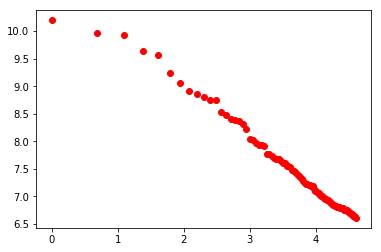

In [13]:
plt.plot([math.log(b) for (a,b) in amb_ranked], [math.log(b) for ((a,b), c) in amb_ranked], 'ro')

In [14]:
from __future__ import division
m = counts_100[0][1]
log_rank = [math.log(b) for (a,b) in amb_ranked]
log_frequency =[math.log(b/m) for ((a,b), c) in amb_ranked]
df = pd.DataFrame(data = {"log_rank":log_rank, "log_frequency":log_frequency})

In [15]:
y, X = dmatrices('log_rank ~ 0 + log_frequency', data=df, return_type='dataframe')

In [16]:
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print "beta = ", result.params[0]

beta =  -1.3149703838205784


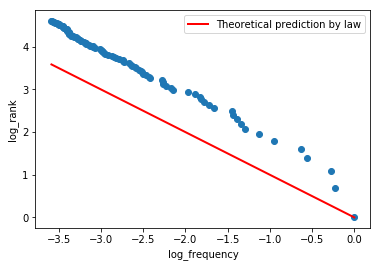

In [17]:
y_theoretical = [-1*x for x in log_frequency]
scatter(x=log_frequency, y=log_rank)
plot(log_frequency, y_theoretical, color='red', linewidth=2, label='Theoretical prediction by law')
xlabel("log_frequency")
ylabel("log_rank")
legend(loc='best')

### A3. If we remove stopwords and lemmatize the data, what are the 10 most common words? What are their frequencies?

Output below.

In [18]:
#From the filtered text(stopwords removed from above steps), we lemmatize the text
wl=WordNetLemmatizer()
filtered_text_lem=[wl.lemmatize(w) for w in filtered_text]
filtered_count_lem=pd.Series(filtered_text_lem)
filtered_count_lem.value_counts().sort_values(ascending=False)[:10]

experience    4341
role          3261
team          3122
client        2940
work          2901
business      2898
skill         2440
service       2392
working       2276
within        2199
dtype: int64

## Part B

### B1. Ignore the job descriptions, and train a model to predict high/low salary from all the numeric columns, e.g., part time/full time, contract vs. others, type of job (a lot of dummy variables), location (instead of using a huge number of dummy variables, you can use a list of cities in England with highest cost of living, and create a 0/1 variable which is 1 if the job is in one of those cities, else 0). Use the Naïve Bayes classifier. What is the accuracy of your model? 

The accuracy of the model on a test set of data (80/20 train / test split) was .734. Unfortunately, this was lower than the Prior Probability of .749. This information, as we have used it, does not appear to be a significant predictor of high vs. low salary jobs in the data.

In [19]:
#Top 29 cities in UK with highest cost of living data from https://www.numbeo.com/cost-of-living/country_result.jsp?country=United+Kingdom 
df_col=pd.read_csv('cost of living.csv')
df_col.head()

,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,1,London,82.75,68.62,76.00,60.24,87.59,97.24
1,2,Reading,77.86,38.41,59.02,67.84,83.26,118.46
2,3,Oxford,73.56,47.24,61.00,53.69,76.78,84.93
3,4,Milton Keynes,72.71,33.10,53.80,62.58,79.06,95.71
4,5,Aberdeen,72.55,27.19,50.90,57.84,91.23,119.55


In [20]:
df_jobs.columns.values

array([u'Id', u'Title', u'FullDescription', u'LocationRaw',
       u'LocationNormalized', u'ContractType', u'ContractTime',
       u'Company', u'Category', u'SalaryRaw', u'SalaryNormalized',
       u'SourceName'], dtype=object)

In [21]:
df_jobs.iloc[3]

Id                                                             72688654
Title                      Technical Architect (Networks) Hertfordshire
FullDescription       Technical Infrastructure Architect, Hertfordsh...
LocationRaw                                               Hertfordshire
LocationNormalized                                        Hertfordshire
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                    Bright Purple Resourcing Ltd
Category                                                        IT Jobs
SalaryRaw                             60k - 75k pa + excellent benefits
SalaryNormalized                                                  67500
SourceName                                                jobsite.co.uk
Name: 3, dtype: object

In [22]:
#Find out the 75th percentile of salary
np.percentile(df_jobs['SalaryNormalized'],75)

42500.0

In [23]:
#Create the target
df_jobs['target']=0.0
mask1=(df_jobs['SalaryNormalized']>=42500)
df_jobs['target'][mask1]=1.0
df_jobs['target'].value_counts()

0.0    1858
1.0     642
Name: target, dtype: int64

In [24]:
#Create 0/1 variable for jobs location using Cost of living data
df_jobs['Location']=0.0
mask2=(df_jobs['LocationNormalized'].isin(list(df_col['City'])))
df_jobs['Location'][mask2]=1.0
df_jobs['Location'].value_counts()

0.0    1800
1.0     700
Name: Location, dtype: int64

In [25]:
#Create other dummy variables
categorical_columns=['ContractType', 'ContractTime', 'Category']
df_dummies=pd.get_dummies(df_jobs[categorical_columns],
                          prefix=categorical_columns,
                          columns=categorical_columns)
dummy_column_names=df_dummies.columns.values
dummy_column_names

array([u'ContractType_full_time', u'ContractType_part_time',
       u'ContractTime_contract', u'ContractTime_permanent',
       u'Category_Accounting & Finance Jobs', u'Category_Admin Jobs',
       u'Category_Charity & Voluntary Jobs', u'Category_Consultancy Jobs',
       u'Category_Creative & Design Jobs',
       u'Category_Customer Services Jobs',
       u'Category_Domestic help & Cleaning Jobs',
       u'Category_Energy, Oil & Gas Jobs', u'Category_Engineering Jobs',
       u'Category_Graduate Jobs', u'Category_HR & Recruitment Jobs',
       u'Category_Healthcare & Nursing Jobs',
       u'Category_Hospitality & Catering Jobs', u'Category_IT Jobs',
       u'Category_Legal Jobs', u'Category_Logistics & Warehouse Jobs',
       u'Category_Maintenance Jobs', u'Category_Manufacturing Jobs',
       u'Category_Other/General Jobs',
       u'Category_PR, Advertising & Marketing Jobs',
       u'Category_Part time Jobs', u'Category_Property Jobs',
       u'Category_Retail Jobs', u'Category_Sale

In [26]:
# Concatenate all these new dummy columns into the old dataframe
df2=pd.concat([df_jobs, df_dummies], axis=1)

In [27]:
# Split into train and test sets
df2_train = df2[:2000]
df2_test = df2[-500:]

In [28]:
#Set up Naïve Bayes classifier
formula= 'target ~ 0 + Location + {}'.format(' + '.join(['Q("{}")'.format(x) for x in dummy_column_names]))
Y_train, X_train=dmatrices(formula,df2_train,return_type='dataframe')
y_train=Y_train['target'].values
print formula
print y[:10]

target ~ 0 + Location + Q("ContractType_full_time") + Q("ContractType_part_time") + Q("ContractTime_contract") + Q("ContractTime_permanent") + Q("Category_Accounting & Finance Jobs") + Q("Category_Admin Jobs") + Q("Category_Charity & Voluntary Jobs") + Q("Category_Consultancy Jobs") + Q("Category_Creative & Design Jobs") + Q("Category_Customer Services Jobs") + Q("Category_Domestic help & Cleaning Jobs") + Q("Category_Energy, Oil & Gas Jobs") + Q("Category_Engineering Jobs") + Q("Category_Graduate Jobs") + Q("Category_HR & Recruitment Jobs") + Q("Category_Healthcare & Nursing Jobs") + Q("Category_Hospitality & Catering Jobs") + Q("Category_IT Jobs") + Q("Category_Legal Jobs") + Q("Category_Logistics & Warehouse Jobs") + Q("Category_Maintenance Jobs") + Q("Category_Manufacturing Jobs") + Q("Category_Other/General Jobs") + Q("Category_PR, Advertising & Marketing Jobs") + Q("Category_Part time Jobs") + Q("Category_Property Jobs") + Q("Category_Retail Jobs") + Q("Category_Sales Jobs") + Q(

In [29]:
#Fit the model
model=naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
prediction_train=model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.758


In [30]:
# Test on test data
Y_test, X_test = dmatrices(formula, df2_test, return_type='dataframe')
y_test = Y_test['target'].values

# Run the test
prediction_test = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction_test)

0.734


In [31]:
#Examine the prior probability
print 'Prior probability for the negative class is',
print exp(model.class_log_prior_[0])
print 'Prior probability for the positive class is',
print exp(model.class_log_prior_[1])

Prior probability for the negative class is 0.749
Prior probability for the positive class is 0.25099999999999995


In [32]:
#Confusion matrix
confusion_matrix(y_test, prediction_test)
#Column names: pred 0 1
#Row names:
#actual
#0
#1

array([[352,   8],
       [125,  15]])

### Now build a classification model with text (full job description) as the only predictor. There are two versions of Naïve Bayes – binomial and multinomial; for the moment, let’s not bother about the theoretical underpinnings! You can use either one for this assignment. For all models, show the confusion matrix.

This model performed much better with a test accuracy of .796 (compared to prior probability of 0.749)

In [33]:
def review_to_words(description):
    letters_only = re.sub("[^a-zA-Z]", " ", description) 
    words = letters_only.lower()
    des = word_tokenize(words)
    return(des)

description = []
n = len(df_jobs["FullDescription"])
for i in range(0,n):
    description.append(review_to_words(df_jobs["FullDescription"][i]))

In [34]:
for i in range(len(description)):
    description[i] = " ".join(description[i])

In [35]:
matrix = CountVectorizer(max_features=2500,stop_words='english')
X = pd.DataFrame(matrix.fit_transform(description).toarray())
X.columns=matrix.get_feature_names()
y = df_jobs["target"]

In [36]:
# Split into train and test sets
X_train = X[:2000]
X_test = X[-500:]
y_train = y[:2000]
y_test = y[-500:]

In [37]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train_pred, y_train)
accuracy_train

0.8155

In [38]:
classifier = naive_bayes.MultinomialNB()
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test_pred, y_test)
accuracy_test

0.796

In [39]:
#Confusion matrix
confusion_matrix(y_test_pred,y_test)

array([[293,  35],
       [ 67, 105]])

In [40]:
feature_importances =classifier.feature_log_prob_[1]
feature_importance_series = pd.Series(feature_importances, index=X.columns.values)
feature_importance_series.sort_values(ascending=False)[:10]

experience    -4.181087
business      -4.405676
role          -4.600606
team          -4.639417
management    -4.800952
work          -4.839243
skills        -4.890732
client        -4.926592
development   -4.957490
manager       -5.082096
dtype: float64

In [41]:
feature_importances =classifier.feature_log_prob_[0]
feature_importance_series = pd.Series(feature_importances, index=X.columns.values)
feature_importance_series.sort_values(ascending=False)[:10]

experience   -4.318628
role         -4.652740
work         -4.697554
team         -4.757658
skills       -4.853790
working      -4.856578
job          -4.872049
business     -4.893540
sales        -4.915503
company      -5.111988
dtype: float64

In [42]:
matrix

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=2500, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

### B2. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 
### Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary. 

We were instructed to disregard this section. These answers can be found in the second half of B1. 

### B3. Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the accuracy of the model. 
### Which model – numeric only, text only and hybrid – provided the highest accuracy in predicting high/low salary? Did the result surprise you? Why or why not?

This "hybrid" model performed with a test accuracy of 0.800 - our best model yet.

It is interesting that adding information from a model that didn't perform well (purely dummy variables) still slightly increased performance of a model that did perform well (job descriptions). However, it is not totally surprising. We can expect that adding more information to a model should increase accuracy as we are testing for it, even slightly. The increase is not substantial, though, and may not be worth seeking when taking bias / variance and accuracy / interpretability trade-offs into consideration.

In [43]:
df3=pd.concat([df_dummies, X, df_jobs['Location']], axis=1)

In [44]:
#Fit the model
X2=df3
y=df_jobs['target']

# Split into train and test sets
X2_train = X2[:2000]
X2_test = X2[-500:]
y_train = y[:2000]
y_test = y[-500:]


model2=naive_bayes.MultinomialNB()
model2.fit(X2_train, y_train)
prediction_train=model2.predict(X2_train)
print metrics.accuracy_score(y_train, prediction_train)

0.818


In [45]:
# Run on test data
y_test_pred = model2.predict(X2_test)
prediction_test = metrics.accuracy_score(y_test_pred, y_test)
prediction_test

0.8

In [46]:
#Confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[292,  68],
       [ 32, 108]])